# Traducteur anglais / français

Dans ce Notebook, nous verrons comment traduire un texte du français vers l'anglais et inversement grâce au modèle pré-entrainé `Word2Vec`.

## Présentation de Word2Vec

Word2Vec est une technique de traitement du langage naturel qui utilise un réseau neuronal pour apprendre les représentations vectorielles des mots dans un texte. Ces représentations peuvent ensuite être utilisées pour identifier les mots qui sont similaires les uns aux autres, pour effectuer des opérations arithmétiques sur les mots (par exemple, "roi" - "homme" + "femme" pourrait donner "reine"), et pour d'autres tâches liées au langage.

Word2Vec ne comprend pas le sens des mots en soi, il est seulement capable de capturer des relations sémantiques et syntaxiques entre les mots.

## Pré-requis

Avant d'utiliser ce notebook, il faut télécharger les jeux de données suivant :
- [Dataset : Traduction Anglais-Français](https://www.kaggle.com/code/jasoncallaway/fra-txt-details/input)
- [French pretained embedding](http://wikipedia2vec.s3.amazonaws.com/models/fr/2018-04-20/frwiki_20180420_100d.txt.bz2)
- [English pretrained embedding](http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2)

### Importation des données

In [1]:
# import data
import pandas
dataset = pandas.read_csv("fra.txt", sep="\t", header=None)
dataset = dataset.drop(2, axis=1) # remove the last column
dataset = dataset.set_axis(['En', 'Fr'], axis=1) # rename columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177210 entries, 0 to 177209
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   En      177210 non-null  object
 1   Fr      177210 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [2]:
# affichage des premières lignes
dataset.head()

,En,Fr
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


### Prétraitement

Nous allons commencer par faire le nettoyage du texte. Cette étape permet de "normaliser" le dataset, afin d'enlever la ponctuation, les mots qui apportent peu d'informations à la compréhension globale de la phrase et la lemmatisation des mots, qui permet de prendre la "racine" du mot. Par exemple, la lemmatisation va enlever les -s du pluriel ou va prendre la racine du mot pour un verbe conjugué. 

In [3]:
# récupérer les données sous forme de liste
en_dataset = dataset['En'].tolist()
fr_dataset = dataset['Fr'].tolist()

en_dataset[:5], fr_dataset[:5]

(['Go.', 'Hi.', 'Hi.', 'Run!', 'Run!'],
 ['Va !', 'Salut !', 'Salut.', 'Cours\u202f!', 'Courez\u202f!'])

Les stopwords sont des listes de mots pour une langue données que l'on retrouve souvent et qui apportent peu d'informations, comme certains mots de liaisons ou des pronoms personnels.

In [4]:
import re
import nltk
from nltk.corpus import stopwords

english_stop_words = set(stopwords.words('english'))
french_stop_words = set(stopwords.words('french'))

In [5]:
def clean_tweet(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    """
    Cette fonction va nettoyer le texte : 
    + mettre en minuscule, 
    + supprimer un certain nombre d'expression,
    + choix lemmatisation / stemming,
    + choix d'une liste de stopwords
    """

    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', '')
    text = ' '.join(text.split())
    text = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", text)
    text = re.sub(r"(\s\-\s|-$)", "", text)
    text = re.sub(r"[,\!\?\%\(\)\/\"]", "", text)
    text = re.sub(r"\&\S*\s", "", text)
    text = re.sub(r"\&", "", text)
    text = re.sub(r"\+", "", text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"\$", "", text)
    text = re.sub(r"\£", "", text)
    text = re.sub(r"\%", "", text)
    text = re.sub(r"\:", "", text)
    text = re.sub(r"\@", "", text)
    text = re.sub(r"\-", "", text)
    text = re.sub(r"\.", "", text)
    text = re.sub(r"\»", "", text)
    text = re.sub(r"\«", "", text)
    
    ## transforme en tokens
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    
                    lst_stopwords]
                
    ## Stemming (supprime -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (retourne la racine du mot)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## liste => string
    text = " ".join(lst_text)
    return text

In [6]:
en_clean = [clean_tweet(text, lst_stopwords=english_stop_words) for text in en_dataset]
fr_clean = [clean_tweet(text, lst_stopwords=french_stop_words) for text in fr_dataset]

en_clean[:5], fr_clean[:5]

(['go', 'hi', 'hi', 'run', 'run'], ['va', 'salut', 'salut', 'cours', 'courez'])

Ici, nous allons importer des modèmes préentrainés de Word2Vec, qui va permettre de transformer les mots en vecteurs.

In [7]:
from gensim.models import keyedvectors
en_trained = keyedvectors.load_word2vec_format("enwiki_20180420_100d.txt.bz2",binary=False,unicode_errors='ignore')
fr_trained = keyedvectors.load_word2vec_format("frwiki_20180420_100d.txt.bz2",binary=False,unicode_errors='ignore')

In [8]:
# transformer les données en vecteurs
import numpy as np

def my_doc_2_vec(doc, trained):
    #dimension de représentation
    p = trained.vectors.shape[1]
    #initialiser le vecteur
    vec = np.zeros(p)
    #nombre de tokens trouvés
    nb = 0
    #traitement de chaque token du document
    for tk in doc:
        #ne traiter que les tokens reconnus
        try:
            values = trained[tk]
            vec = vec + values
            nb = nb + 1.0
        except:
            pass
    #faire la moyenne des valeurs
    #uniquement si on a trové des tokens reconnus bien sûr
    if (nb > 0.0):
        vec = vec/nb
    #renvoyer le vecteur
    #si aucun token trouvé, on a un vecteur de valeurs nulles
    return vec

In [10]:
en_docs_vec = list()
fr_docs_vec = list()

for doc in en_clean:
    en_docs_vec.append(my_doc_2_vec(doc.split(), en_trained))
    
for doc in fr_clean:
    fr_docs_vec.append(my_doc_2_vec(doc.split(), fr_trained))
    
# transformer en matrice
en_docs_vec = np.array(en_docs_vec)
fr_docs_vec = np.array(fr_docs_vec)

en_docs_vec.shape, fr_docs_vec.shape

((177210, 100), (177210, 100))

### Prédiction et évaluation en test

On commence par regarder si un GPU est disponible.

In [11]:
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        #Currenlty memory growth needs to be the same across GPUs
        for gpu in gpus :
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical devices", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2024-03-19 15:10:05.160122: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 15:10:05.399135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 15:10:05.399160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 15:10:05.435679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 15:10:05.508802: I tensorflow/core/platform/cpu_feature_guar

1 Physical devices 1 Logical GPUs


2024-03-19 15:10:06.688185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 15:10:06.811110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 15:10:06.811273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Nous allons maintenant séparé les données en train, val et test. Cela va permettre d'entrainer le modèle sur des données d'entrainements, et utiliser des données de tests pour vérifier si le modèle fonctionne.

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    fr_docs_vec,
    en_docs_vec,
    test_size=0.8,
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    train_size=0.8,
    random_state=42
)

print("========== Données d'entraînement ========== \n", x_train,  "\n",
      "========== Données de validation ========== \n", x_test,  "\n",
      "========== Données de test ========== \n", x_val)

========== Données d'entraînement ========== 
 [[-0.2906      0.0067      0.0588     ... -0.74779999  0.37850001
  -0.3511    ]
 [-0.3398      0.007675    0.02454999 ... -0.35827501  0.067825
  -0.260175  ]
 [-0.08856667 -0.19393334  0.25673333 ... -0.27260001  0.15606667
  -0.27996666]
 ...
 [-0.2291     -0.1399     -0.1893     ... -0.28650001  0.0126
  -0.35870001]
 [-0.03293334 -0.09093333  0.19826667 ... -0.42256666  0.225
  -0.23193333]
 [-0.30660001 -0.25176667  0.2143     ... -0.78603335  0.16503334
  -0.15873333]] 
 ========== Données de validation ========== 
 [[-0.03316667  0.09573333  0.27126667 ... -0.35866666 -0.1393
  -0.29043333]
 [-0.0864     -0.19525     0.26835    ... -0.76305    -0.0428
   0.15085   ]
 [-0.154425   -0.1982      0.1426     ... -0.28205    -0.09257501
  -0.57450001]
 ...
 [-0.13712    -0.0723     -0.0282     ... -0.65748     0.28998
  -0.17202   ]
 [-0.33025     0.95025     0.01805    ... -0.0182      0.28180001
  -0.50505   ]
 [-0.24464999 -0.108725  

## Construisons le modèle

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

model = Sequential()
model.add(Flatten(input_shape=(100,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(100, activation='tanh'))

adam = Adam(
    learning_rate=0.001
)

# Compiler le modèle
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['acc'])

In [36]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               25856     
                                                                 
 dense_15 (Dense)            (None, 100)               25700     
                                                                 
Total params: 51556 (201.39 KB)
Trainable params: 51556 (201.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/30


444/444 [==============================] - 1s 985us/step - loss: 0.0300 - acc: 0.4182 - val_loss: 0.0254 - val_acc: 0.4743
Epoch 2/30
444/444 [==============================] - 0s 884us/step - loss: 0.0251 - acc: 0.4670 - val_loss: 0.0244 - val_acc: 0.4854
Epoch 3/30
444/444 [==============================] - 0s 886us/step - loss: 0.0243 - acc: 0.4757 - val_loss: 0.0240 - val_acc: 0.4888
Epoch 4/30
444/444 [==============================] - 0s 880us/step - loss: 0.0238 - acc: 0.4803 - val_loss: 0.0238 - val_acc: 0.4932
Epoch 5/30
444/444 [==============================] - 0s 886us/step - loss: 0.0234 - acc: 0.4855 - val_loss: 0.0234 - val_acc: 0.5013
Epoch 6/30
444/444 [==============================] - 0s 882us/step - loss: 0.0231 - acc: 0.4896 - val_loss: 0.0233 - val_acc: 0.5013
Epoch 7/30
444/444 [==============================] - 0s 889us/step - loss: 0.0228 - acc: 0.4911 - val_loss: 0.0230 - val_acc: 0.5022
Epoch 8/30
444/444 [==============================] - 0s 871us/step - los

## Données de test

In [43]:
loss, acc = model.evaluate(x_test, y_test)

 303/4431 [=>............................] - ETA: 2s - loss: 0.0226 - acc: 0.4958

4431/4431 [==============================] - 2s 496us/step - loss: 0.0228 - acc: 0.4947


In [44]:
print(f"La perte est de {loss} et l'accuracy {acc}.")

La perte est de 0.02282661385834217 et l'accuracy 0.49465322494506836.


Nous pouvons remarquer que le modèle est capable de prédire la moitié des traductions, ce qui reste relativement peu. On peut donc se poser la question s'il était pertinent d'utiliser Word2Vec pour faire de la traduction ou s'il y a plutôt un problème dans la manière d'avoir prétraité et utilisé les données.

## Visualisation

Text(0, 0.5, 'Loss & Acc')

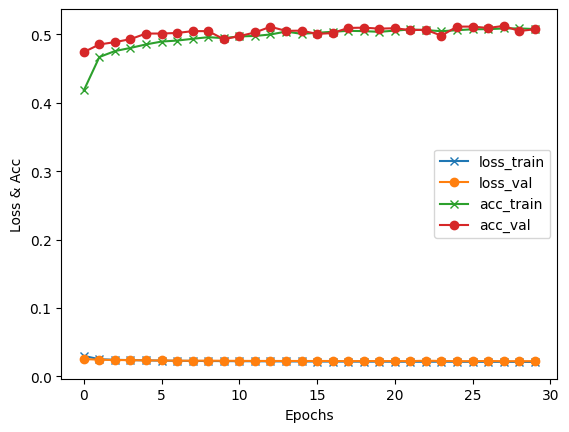

In [45]:
import matplotlib.pyplot as plt

epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label="loss_train", marker='x')
plt.plot(range(epochs), history.history['val_loss'], label="loss_val", marker='o')
plt.plot(range(epochs), history.history['acc'], label="acc_train", marker='x')
plt.plot(range(epochs), history.history['val_acc'], label="acc_val", marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss & Acc')

## Test du traducteur

In [58]:
word = "quelque chose"

clean_word = clean_tweet(word, lst_stopwords=french_stop_words)
vec_word = my_doc_2_vec(clean_word.split(), fr_trained)

vec_translated_word = model.predict(np.array([vec_word]))
translated_word = en_trained.most_similar([vec_translated_word[0]], topn=1)[0][0]
print(translated_word)


1/1 [==============================] - 0s 8ms/step
something


En faisant plusieurs tests, nous remarquons que nous sommes capable de traduire certains mots simples comme "chien", "chat" ou "quelquechose", mais nous avons beaucoup de problèmes à traduire la majorité des mots.